<a href="https://colab.research.google.com/github/kaori-kanno/heart_recon/blob/main/recon_test_parteIyII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Usar GPU T4, si se requiere de hacer algo muy pesado, el A100

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
# import inrmri

In [52]:
from google.colab import drive
import os

drive.mount('/content/drive') # directorio de todas las carpetas
os.chdir("/content/drive/MyDrive/joint_recon/Pig_2")
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
diffusion_directions.txt  kspace_real.mat   results_out3.pkl
image_imag.mat		  NF-cMRI-tabita    training_results_100k.pkl
image_real.mat		  results_out1.pkl  training_results_lr.pkl
kspace_imag.mat		  results_out2.pkl


In [53]:
# ir = loadmat('Pig_2/image_real.mat')['image_real']
# im = loadmat('Pig_2/image_imag.mat')['image_imag']

ir_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_real.mat')
im_data = loadmat('/content/drive/MyDrive/joint_recon/Pig_2/image_imag.mat')

In [54]:
real = ir_data['image_real']
imag = im_data['image_imag']

In [55]:
# kr = loadmat('Pig_2/kspace_real.mat')['kspace_real']
# ki = loadmat('Pig_2/kspace_imag.mat')['kspace_imag']

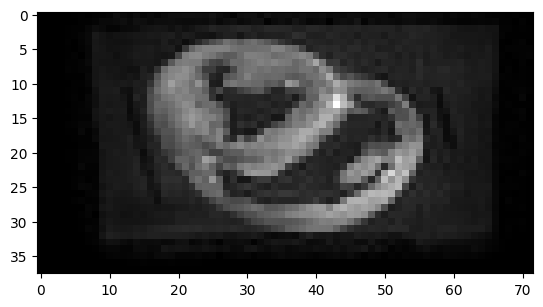

In [56]:
image = real + 1j*imag # combinamos la parte real e imaginaria para formar la imagen completa
image = image/np.max(np.abs(image)) # se normaliza la imagen por el valor máximo

plt.imshow(np.abs(image[:,:,24,4,1]), cmap='gray') # seleccionamos el corte 24, y ciertas direcciones de difusión

In [57]:
print(image.shape) # (x, y, z, valores_b, direcciones)

(38, 72, 49, 5, 457)


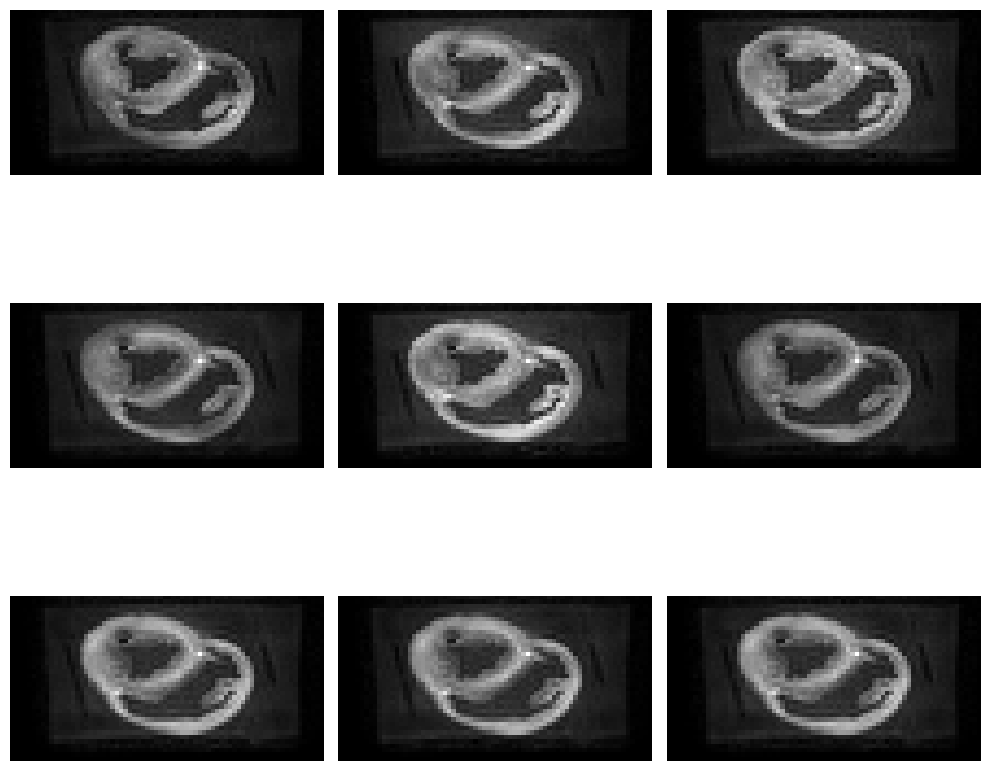

In [58]:
plt.figure(figsize=(10,10))

for i in range(1, 10):
    plt.subplot(3,3,i)
    plt.imshow(np.abs(image[:,:,24,4,i]), cmap='gray') # cambiamos la última dirección i de difusión

    plt.axis('off')

plt.tight_layout()

In [59]:
# recortamos un slice de todas las imágenes en el plano XY
slice = image[:,:,24,4,:]
slice = np.transpose(slice, (2,0,1))
slice.shape

(457, 38, 72)

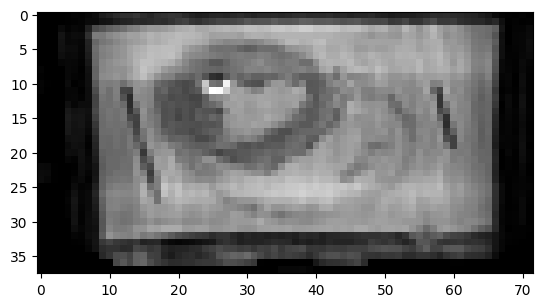

In [60]:
M0 = image[:,:,24,0,0].copy() # imagen con b = 0 en corte 24
M0mask = np.abs(M0) > 0

plt.imshow(np.abs(M0), cmap='gray')

In [61]:
np.abs(M0).min(), np.abs(M0).max() # valores de grises mínimos y máximos en M0

(np.float32(0.0), np.float32(0.86845744))

In [62]:
# aplicamos Fourier en las imágenes

k_space = np.fft.fft2(slice)
k_space.shape

(457, 38, 72)

In [63]:
n_masks = 6 # se crean máscaras en el espacio k para simular un muestreo de las imágenes
masks = []
max_lines = 11 # máximo de líneas que conservaremos en cada máscara.
bandwith = 3 # bandas a conservar al centro y a los extremos (información muy relevante en la imagen)
for i in range(n_masks):
    mask = np.zeros(k_space.shape[1:]).astype(bool) # creamos la máscara
    mask[np.arange(i,k_space.shape[1],6)] = 1 # en la máscara creada, marca como 1 (o True) cada 6 pasos, partiendo en i.


    # se conservan la banda superior e inferior como 1 o True:
    mask[-bandwith:] = 1
    mask[:bandwith] = 1

    if mask[:,0].sum() > max_lines: # si se excede el número de líneas permitidas
        idxs = np.where(mask[:,0]>0)[0] # se obtienen los índices de las filas
        order = np.argsort(np.abs(idxs - mask.shape[0]//2))
        idx = idxs[order][:(mask[:,0].sum() - max_lines)] # se ordenan las filas
        print(idx, mask[idxs[0],0])
        mask[idx,:] = 0 # se hacen 0 o False las líneas más alejadas del centro.

    masks.append(mask)
    print(mask[:,0].sum()) # imprimimos la suma de los valores que están en la fila 0 (deberían sumar max_lines)





11
11
11
[21] True
11
[22] True
11
11


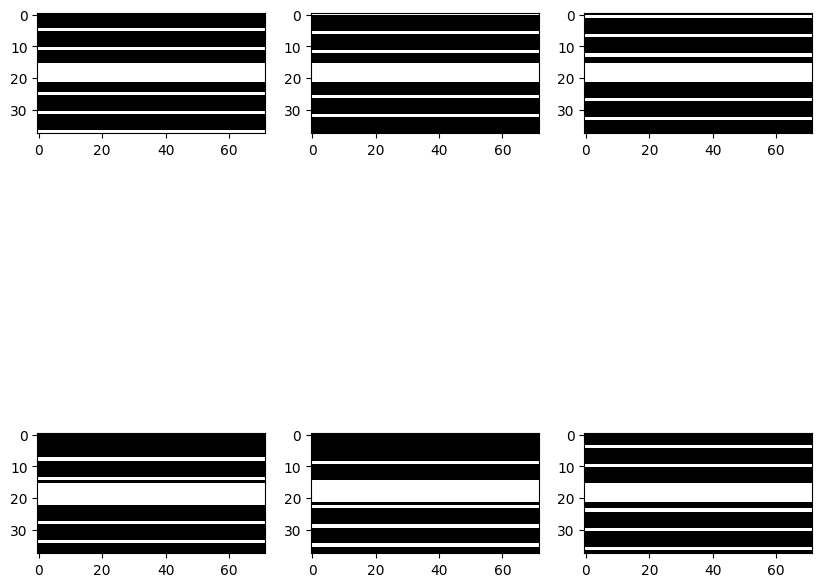

In [64]:
# ploteamos las máscaras

plt.figure(figsize=(10,10))

for i, mask in enumerate(masks):
    plt.subplot(2,3,i+1)
    plt.imshow(np.fft.fftshift(mask), cmap='gray')

plt.show()

In [65]:
k_space.shape[1]/mask[:,0].sum() # cantidad de imágenes / cantidad de filas

np.float64(3.4545454545454546)

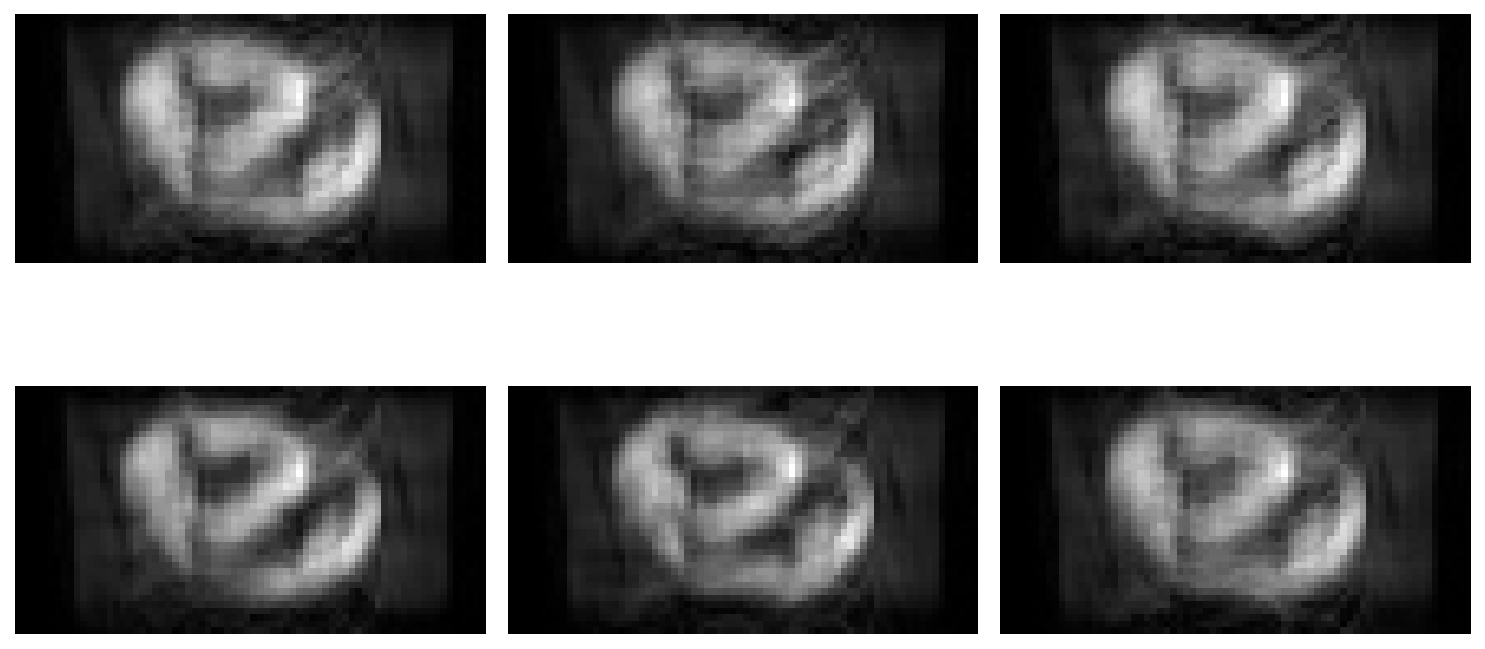

In [66]:
plt.figure(figsize=(10,6), dpi = 150)

for i, mask in enumerate(masks):
    plt.subplot(2,3,i+1) # cuadrícula para los plots
    under_k_space = np.zeros(k_space.shape[1:], dtype=np.complex128)
    under_k_space[mask] = k_space[1][mask] # Se aplica mask sobre  k_space y se seleccionan solo las frecuencias de k_space[1] marcadas

    under_i = np.fft.ifft2(under_k_space) # Se realiza la transformada inversa de Fourier 2D (ifft2) sobre under_k_space

    plt.imshow(np.abs(under_i), cmap='gray') # se muestra la imagen reconstruída submuestreada.
    plt.axis('off')

plt.tight_layout()


## neural network

In [67]:
import os

os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"

import jax.numpy as np
from jax import random, grad, jit, vmap
import jax
from jax.scipy.optimize import minimize
import numpy as onp
from jax.experimental.ode import odeint
from jax.example_libraries import optimizers
from functools import partial
from matplotlib import pyplot as plt
from jax.nn import relu
key = random.PRNGKey(0)

In [68]:
def init_params(layers, key):
  Ws = [] # lista de matrices de pesos
  bs = [] # lista de vectores de sesgos
  for i in range(len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1])) # mediante glorot se definen los pesos
    key, subkey = random.split(key) # mantiene aleatoriedad controlada, mediante jax se asignan los pesos random
    Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    bs.append(np.zeros(layers[i + 1])) # se crean los pesos en 0
  return (Ws, bs)

@jit
def forward_pass(H, params):
  """
  Esta es un MLP
  """
  Ws = params[0]
  bs = params[1]
  N_layers = len(Ws)
  for i in range(N_layers - 1):
    H = np.matmul(H, Ws[i]) + bs[i] # multiplicación de los pesos + bias
    H = np.tanh(H) # función de activación no lineal aplicada en la red
  Y = np.matmul(H, Ws[-1]) + bs[-1] # capa final sin función de activación
  return Y

def init_params_icnn(layers, key):
  Wz = [] # pesos aplicados a Z (capas intermedias)
  Wy = [] # pesos aplicados a Y (input original)
  bs = [] # bias para cada capa oculta

  std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
  key, subkey = random.split(key)
  Wy.append(random.normal(subkey, (layers[0], layers[1]))*std_glorot)

  for i in range(1,len(layers) - 1):
    std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
    key, subkey = random.split(key)
    Wz.append(-3 + random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot) #Wz recibe pesos inicializados con ruido negativo (-3 + random...) para garantizar valores pequeños
    Wy.append(random.normal(subkey, (layers[0], layers[i + 1]))*std_glorot) # se conecta la capa de entrada, 0, con las capas ocultas
    bs.append(np.zeros(layers[i + 1]))
  return (Wz, Wy, bs)

@jit
def icnn_forwardpass(Y, params): # se recorren hacia adelante las capas
  """
  Esta es un ICNN
  """
  Wz, Wy, bs = params
  N_layers = len(Wy)
  Z = relu(np.matmul(Y, Wy[0]) + bs[0])  # esta es la capa de entrada Y
  for i in range(1, N_layers - 1): # aquí se recorren las capas intermedias
    Z = np.matmul(Z, np.exp(Wz[i-1])) + np.matmul(Y, Wy[i]) + bs[i]
    Z = relu(Z) # se da una función de activación
  Z = np.matmul(Z, np.exp(Wz[-1])) + np.matmul(Y, Wy[-1]) + bs[-1]  # última capa, sin activación no lineal
  return Z


@jit
def ff_forwardpass_B(X, params, B):
  """
  Aplicar Fourier a la data de entrada x.
  B es una matriz
  """
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X) # calcula el producto punto entre cada fila de X y B, B @ X.T
  # estos son los ángulos de los features
  gamma = np.concatenate((np.sin(angles), np.cos(angles)), axis = 1) # Fourier Feature Mapping, un truco para mapear tus datos a un espacio más rico.
  return forward_pass(gamma, params)  #  se pasa gamma por el MLP forward_pass

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)  # extrae los parámetros
    g = grad(loss)(params, X_batch, Y_batch)  # calcula el gradiente de la función de pérdida respecto a los parámetros
    return opt_update(i, g, opt_state) # actualiza los parámetros con un tamaño adecuado

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    """
    Aquí entrenamos el modelo para varias iteraciones con batches de data X e Y que se crean aquí
    """
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        # idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False) # toma un batch aleatorio
        opt_state = step(loss, it, opt_state, X, Y) # actualiza los parámetros con step
       # opt_state = step(loss, it, opt_state, X, Y)
        if it % 100 == 0:  # cada 100 iteraciones:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y) # train_loss_value = loss(params, X[idx_batch], Y[idx_batch])
            train_loss.append(train_loss_value)  # mide la pérdida del batch
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return opt_state, train_loss, val_loss

def train_batch(loss, Xb, Yb, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    it = 0
    while it < nIter: # itera en los batches
        for X, Y in zip(Xb, Yb): # Xb, Yb son listas de batches
          opt_state = step(loss, it, opt_state, X, Y)
          it += 1
          if it % 100 == 0:
              params = get_params(opt_state)
              train_loss_value = loss(params, X, Y)
              train_loss.append(train_loss_value)
              to_print = "it %i, train loss = %e" % (it, train_loss_value)
              print(to_print)
    return get_params(opt_state), train_loss, val_loss

def create_batches(input, output, batch_size):
    """
    Divide los datos en mini-batches y los devuelve
    """
    # Ensure input and output have the same first dimension length
    assert input.shape[0] == output.shape[0], "Input and output must have the same number of samples"

    num_samples = input.shape[0]  # número de muestras totales

    # Shuffle indices
    shuffled_indices = random.permutation(jax.random.PRNGKey(0), num_samples) # Crea un orden aleatorio de los índices (0 a num_samples-1)
    input_shuffled = input[shuffled_indices]
    output_shuffled = output[shuffled_indices] # reordena las muestras del output

    # Split the data into batches
    # Devuelve listas con batches de X e Y, listas de tamaño num_batches.
    input_batches = np.array_split(input_shuffled, num_samples // batch_size)
    output_batches = np.array_split(output_shuffled, num_samples // batch_size)

    return input_batches, output_batches




In [69]:
@jit
def cartesian_to_spherical(x):
    """
    Se toma un vector 3D y se convierte a esféricas
    """
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    theta = np.arccos(x[2] / r)  # polar angle
    phi = np.arctan2(x[1], x[0])    # azimuthal angle
    return r, theta, phi

In [70]:
# cargamos las direcciones de gradiente de difusión, son 457

dirs = onp.genfromtxt('diffusion_directions.txt', delimiter=';')

R, Theta, Phi= vmap(cartesian_to_spherical)(dirs) # vmap opera sobre un batch o conjunto de datos la operación dada

As = np.cos(Theta) # proyección en z de las direcciones
Bs = np.cos(Phi) # proyección en el plano XY



Acabamos de procesar direcciones existentes, podemos ahora mapear direcciones ideales:

In [71]:
import mpl_toolkits.mplot3d

num_pts = 24
b_value = 6500
indices = np.arange(0, num_pts, dtype=float) + 0.5  # entrega valores igualmente espaciados en el rango (0, num_pts)
# sumamos 0.5 para que no sean los puntos de los extremos o los polos de la esfera.

phi = np.arccos(1 - 2*indices/num_pts) # esfera de Fibonacci
theta = np.pi * (1 + 5**0.5) * indices # esfera de Fibonacci, espiral con proporción áurea

# convertimos de esféricas a cartesianas con r = 1
# fórmula de fibonachi para una esfera donde los puntos están equidistantes repartidos.
x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)


# solo necesitamos mapear en una semi-esfera por simetría:
x_half = x[np.where(z >=0)]
y_half = y[np.where(z >=0)]
z_half = z[np.where(z >=0)]
b_value = np.repeat(b_value,x_half.shape[0])  # añadimos b al arreglo



directions = np.array([x_half,z_half,y_half]).transpose() # vector de dirección en 3d, (x, z, y)

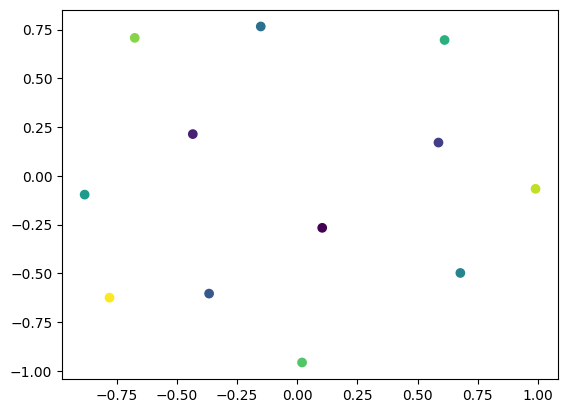

In [72]:
plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))

Array([0.99878776, 0.997787  , 0.99924225, 0.99934345, 0.99963474,
       0.99877995, 0.99890304, 0.99883866, 0.99909306, 0.9991266 ,
       0.9997292 , 0.9977222 ], dtype=float32)

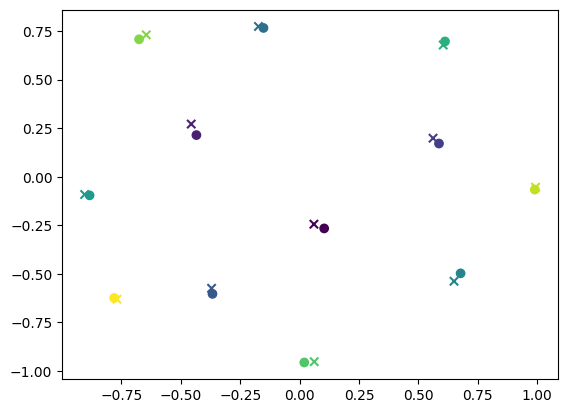

In [73]:
# calculamos el producto punto entre cada dirección dir creada de direction con las otras direcciones dirs del scaner
ort = vmap(lambda dir, dirs: np.dot(dir,dirs), in_axes=(None, 0))(directions, dirs)


selected_dirs = np.argmax(ort, axis = 0) # el de mayor producto punto será la dirección más cercana
selected_dirs_vec = dirs[selected_dirs] # guardamos esas direcciones

plt.scatter(x_half, y_half, c = np.arange(x_half.shape[0]))
plt.scatter(selected_dirs_vec[:,0], selected_dirs_vec[:,2], c = np.arange(x_half.shape[0]), marker = 'x')
np.max(ort, axis = 0)

In [74]:
# coordenadas del sistema:
Nx = k_space.shape[1] # tamaño de la transformada de fourier en x
Ny = k_space.shape[2] # tamaño de la transformada de fourier en y
x = np.arange(Nx)/(Nx - 1)*2 - 1 # normaliza las coordenadas Nx a valores entre -1 y 1
y = np.arange(Ny)/(Nx - 1)*2 - 1 # [0 a Ny-1]/(Ny-1) = [0 - 1]

X, Y = np.meshgrid(x, y, indexing = 'ij') # X, Y = np.meshgrid(x, y)
Xall = np.c_[X.flatten(), Y.flatten()] # aplana y concatena X con Y

# creamos las máscaras
masks = np.array(masks)
masks_rep = np.concatenate((masks, masks), axis = 0)  # se le agregan máscaras # masks_rep = np.concatenate((masks, masks[:3]), axis = 0)
input = []
output = []

for i,dir_idx in enumerate(selected_dirs): # son 9 puntos en selected_dirs
    input.append(np.c_[Xall, np.ones(Xall.shape[0])*As[dir_idx], np.ones(Xall.shape[0])*Bs[dir_idx]]) # (xs, ys, cos(th), cos(phi))
input = np.array(input)
# recordar que Xall.shape = (Nx * Ny, 2) y As[dir_idx] sería la dirección de un vector de selected_dirs



print(k_space[selected_dirs].shape) # (num_puntos 12, x, y)
output = k_space[selected_dirs][masks_rep] # se le aplica la máscara a las direcciones seleccionados.
print(input.shape, output.shape) # (num_puntos 12, num_puntos_visibles Nx*Ny, 4 (x, y, cos, cos)) y un valor


(12, 38, 72)
(12, 2736, 4) (9504,)


### first training

In [95]:
masks = np.array(masks)

@jit
def forward_model(X, params):
    I = ff_forwardpass(X, params) # pasa por la función de más abajo que lleva a ff_forwwardpass_mixed
    I = I[:,0] + 1j*I[:,1] # se convierte la imagen a una compleja
    I = I.reshape((Nx, Ny)) # I = I.reshape(mask.shape) # se reconstruye la imagen
    k_space = np.fft.fft2(I) # transforma a k-space
    return k_space

n_pix = k_space.shape[1]*k_space.shape[2]

@jit
def loss(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  return np.mean(np.abs((np.squeeze(k_spaces[masks_rep]) - Y))**2/(n_pix)) # se calcula el error entre el k-space simulado y el real partido en npix


@jit
def ff_forwardpass_mixed(X, params, B):
  angles = 2*np.pi*vmap(np.dot, in_axes = (None, 0))(B, X[:,:2]) # 2pi * (proyecciones)
  input = np.concatenate((np.sin(angles), np.cos(angles), X[:,2:]), axis = 1)
  return forward_pass(input, params)

sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

layers = [2*N_ff+2, 256, 256,256, 2] # define las capas de la red; capa de entrada, 3 capas ocultas de 256 neuronas y 2 neuronas de salida para parte real e im
params = init_params(layers, key)



In [96]:
def psnr(params, input, Y):

  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  print(k_spaces.shape)
  mse = np.mean(np.abs((k_spaces - Y))**2/(n_pix))
  max_value = np.max(np.abs(Y))
  return 20 * np.log10(max_value / (np.sqrt(mse)))

In [97]:
def loss_orig(params, input, Y):
  k_spaces = vmap(partial(forward_model, params = params))(input) # simula varios k-space con forward_model
  return np.mean(np.abs((k_spaces - Y))**2/(n_pix))

In [98]:
#lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.99)
opt_init, opt_update, get_params = optimizers.adam(1e-3)  #  Adam con learning rate 1e-3
opt_state = opt_init(params)
# opt_state_mil, train_loss, val_loss = train(loss,input, output, opt_state, key, nIter= 1000) # 1000

In [99]:
import pickle
save_path='/content/drive/MyDrive/joint_recon'


In [100]:
# with open(f'{save_path}/params_100mil.pkl', "rb") as f:
#     params_100mil = pickle.load(f)

# with open(f'{save_path}/opt_state_100mil.pkl', "rb") as f:
#     opt_state_100mil = pickle.load(f)

In [101]:
with open(f'{save_path}/params_200mil.pkl', "rb") as f:
    params_200mil = pickle.load(f)

with open(f'{save_path}/opt_state_200mil.pkl', "rb") as f:
    opt_state_200mil = pickle.load(f)

#### Second try first training:

Probamos aquí cambiando el número de neuronas de cada capa

In [102]:
with open(f'{save_path}/params_1.pkl', "rb") as f:
    params1 = pickle.load(f)

with open(f'{save_path}/opt_state_1.pkl', "rb") as f:
    opt_state1 = pickle.load(f)

Probamos ahora cambiar el número de capas en sí

In [103]:
with open(f'{save_path}/params_2.pkl', "rb") as f:
    params2 = pickle.load(f)

with open(f'{save_path}/opt_state_2.pkl', "rb") as f:
    opt_state2 = pickle.load(f)

Agregamos un decay en el learning rate

In [104]:
with open(f'{save_path}/params_lr_exp.pkl', "rb") as f:
    params_lr_exp = pickle.load(f)

with open(f'{save_path}/opt_state_lr_exp.pkl', "rb") as f:
    opt_state_lr_exp = pickle.load(f)

In [105]:
with open(f'{save_path}/params_lr_exp200.pkl', "rb") as f:
    params_lr_exp200 = pickle.load(f)

with open(f'{save_path}/opt_state_lr_exp200.pkl', "rb") as f:
    opt_state_lr_exp200 = pickle.load(f)

In [106]:
with open(f'{save_path}/params_sigma4.pkl', "rb") as f:
    params_sigma4 = pickle.load(f)

with open(f'{save_path}/opt_state_sigma4.pkl', "rb") as f:
    opt_state_sigma4 = pickle.load(f)

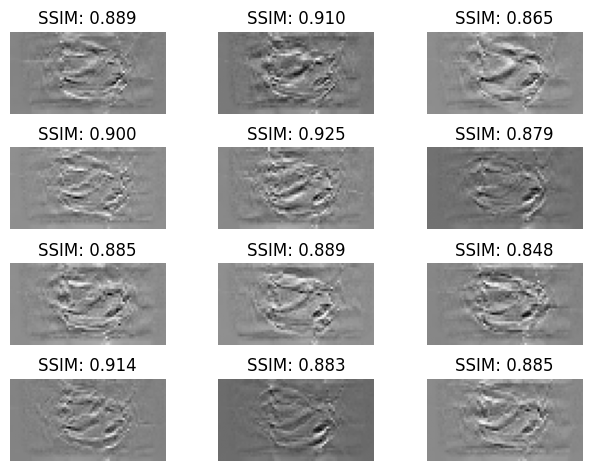

In [107]:
from skimage.metrics import structural_similarity as ssim

sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)

for i, idx in enumerate(selected_dirs):
    plt.subplot(4, 3, i+1)

    inp = input[i]
    Img = ff_forwardpass(inp, params_sigma4)
    Img = Img[:, 0] + 1j * Img[:, 1]
    I_img = np.abs(Img).reshape((Nx, Ny))

    gt_img = np.abs(slice[idx])
    img = gt_img  # ya tiene la forma correcta

    diff = I_img - img
    ssim_val = ssim(I_img, img, data_range=img.max() - img.min())

    plt.imshow(diff, cmap='gray')
    plt.title(f'SSIM: {ssim_val:.3f}')
    plt.axis('off')

plt.tight_layout()

#### Con toda los puntos visibles

In [108]:
sigma = 0.15
N_ff = 256
key = random.PRNGKey(0)
B = random.normal(key, shape = (N_ff,2))*sigma # B es aleatorio

ff_forwardpass = lambda x, params: ff_forwardpass_mixed(x,params,B)


In [109]:
# with open(f'{save_path}/params_cienmil_todo.pkl', 'wb') as f:
#     pickle.dump(params_cienmil_todo, f)

# with open(f'{save_path}/opt_state_cienmil_todo.pkl', 'wb') as f:
#     pickle.dump(opt_state_cienmil_todo, f)

with open(f'{save_path}/params_cienmil_todo.pkl', "rb") as f:
    params_cienmil_todo = pickle.load(f)

with open(f'{save_path}/opt_state_cienmil_todo.pkl', "rb") as f:
    opt_state_cienmil_todo = pickle.load(f)

In [110]:
params_cienmil_todo = get_params(opt_state_cienmil_todo)
loss(params_cienmil_todo, input, output)

Array(7.0597457e-06, dtype=float32)

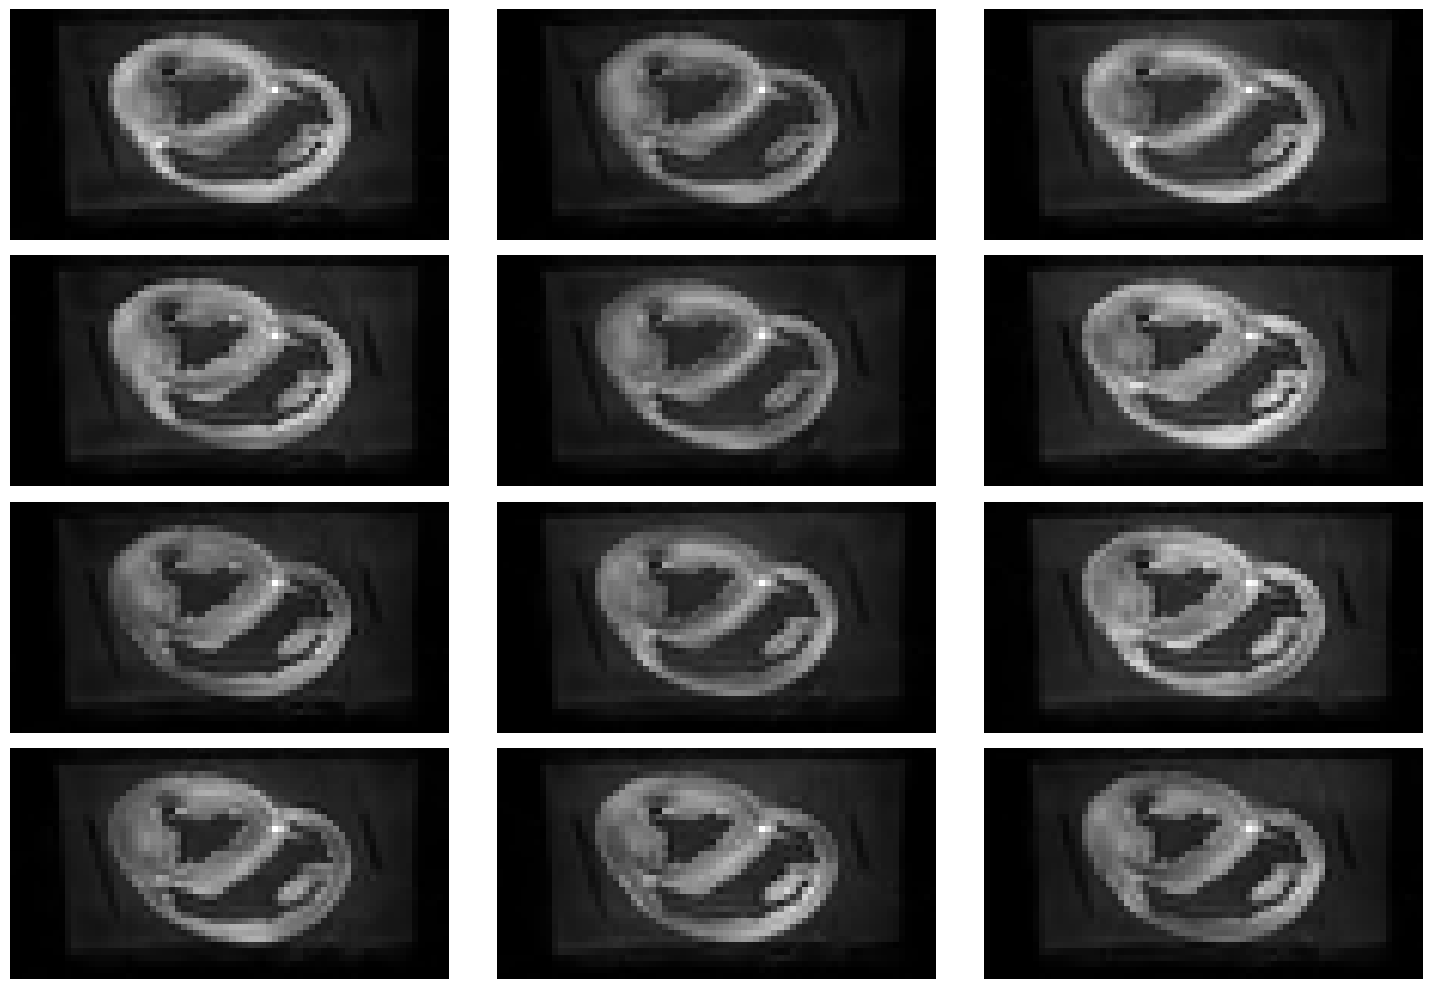

In [111]:
plt.figure(figsize=(15,10))

for i, inp in enumerate(input):
    plt.subplot(4,3,i+1)
    I = ff_forwardpass(inp, params_cienmil_todo)
    I = I[:,0] + 1j*I[:,1] # imagen reconstruida a partir de los parámetros.
    plt.imshow(np.abs(I).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

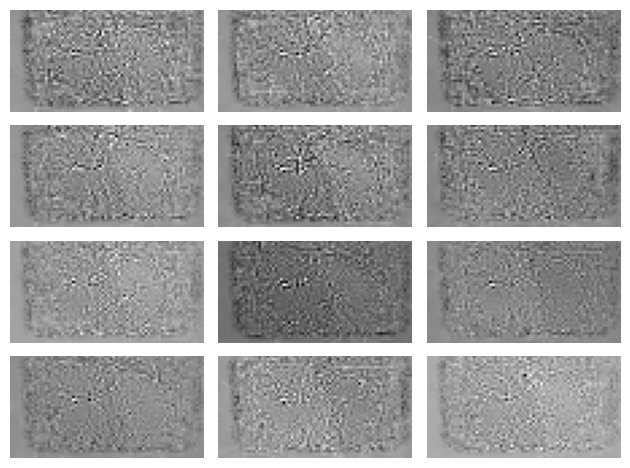

In [112]:
for i, idx in enumerate(selected_dirs):
    plt.subplot(4,3,i+1)
    inp = input[i]
    Img = ff_forwardpass(inp, params_cienmil_todo)
    Img = Img[:,0] + 1j*Img[:,1] # imagen reconstruida a partir de los parámetros.
    I_img = np.abs(Img).reshape((Nx, Ny))
    # print(I_img.shape)
    # print(slice[idx].shape)
    plt.imshow((np.abs(I_img) - np.abs(slice[idx])).reshape((Nx, Ny)), cmap='gray')
    plt.axis('off')

plt.tight_layout()

## Parte II

### second training:
 Aquí se usa $M_0$, la magnitud en $b_0$

In [113]:
# params_probar = params_lr_exp200
# nombre = "fiber_lr_exp200"

# params_probar = params2
# nombre = "fiber2"

params_probar = params_200mil
nombre = "fiber3"

In [114]:
input_f = [] # lista de inputs para cada dirección
output_f = [] # lista de outputs para cada dirección

for i,dir_idx in enumerate(selected_dirs): # se itera sobre las direcciones dir_idx
    input_f.append(np.c_[Xall,np.tile(dirs[dir_idx], (Xall.shape[0],1))]) # posiciones X_all + direcciones dirs[10] = num_pixeles, 2 posiciones + 3 direcciones (x, y, z), simulamos solo la direccion 10
    Img = ff_forwardpass(input[i], params_probar)
    Img = Img[:,0] + 1j*Img[:,1] # reconstruimos la imagen i
    output_f.append(np.log(np.abs(Img)+1e-6)) # agregamos log para trabajar en escala logarítmica, +1e-6 evita log(0)


# convertimos las listas a arrays:
input_f = np.array(input_f)
output_f = np.array(output_f)

logM0 = np.log(np.abs(M0)).ravel()
M0mask = np.array(M0mask).ravel() # selecciona los puntos dentro de M0, evitando ruido del fondo

Aquí, una es una parte isotrópica dada por dI y otra es la parte anisotrópica dada por df. Esto indica cuánta difusión hay, y por tanto indica cuánto se atenúa la señal.

In [115]:
@jit
def log_forward_model(input, params):
  X = input[:,:2] # primeras coordenadas, (x,y)
  BN = input[:,2:] # proyecciones de difusión, 6
  pred = ff_forwardpass_fiber(X, params) # output es de tamaño (N, 4)
  dI = np.exp(pred[:,0]) # difusión intracelular isotrópica, qué tan homogénea se difunde el agua
  df = np.exp(pred[:,1]) # difusión extracelular en dirección de la fibra, cuánto aporta la dirección de la fibra a la difusión
  a = np.tanh(pred[:,2]) # ángulo en una esfera, también determina f2
  b = np.tanh(pred[:,3]) # otro ángulo que determina f1, f2 y f3

  # componentes de dirección de las fibras en 3D:
  f1 = a*np.sqrt(1 - b**2 + 1e-6) # cómo cambia la orientación de la fibra en X
  f2 = np.sqrt(1 - a**2 + 1e-6)*np.sqrt(1 - b**2 + 1e-6)
  f3 = b

  # simula la atenuación de la señal:
  Dproj = BN[:,0]*(dI + df*f1**2) + BN[:,1]*(dI + df*f2**2) + BN[:,2]*(dI + df*f3**2) + \
         + df*(BN[:,3]*f1*f2 + BN[:,4]*f1*f3 + BN[:,5]*f2*f3)

  return logM0 - Dproj # esto es señal con atenuación

N_ff = 256
key = random.PRNGKey(1234)
Bf = random.normal(key, shape = (N_ff,2))*3 # was 3

ff_forwardpass_fiber = lambda X, params: ff_forwardpass_B(X,params,B)


@jit
def loss(params, input, Y):
  pred = vmap(log_forward_model, in_axes=(0,None))(input, params) # se aplica log_forward_model a cada input
  MSE_data = np.average((pred[:,M0mask] - Y[:,M0mask])**2) # se comparan los valores dentro de la máscara de píxeles válidos
  return  MSE_data
# @jit
# def joint_loss(params, input, Y):
#   input_I, input_f = input
#   logIf = log_forward_model(input_f, params)

#   MSE_data = np.average((pred - Y[:,0])**2)
#   return  MSE_data

output /= output.max()

layers = [2*N_ff, 256, 256,256, 4] # dimensiones de B

params_fiber = init_params(layers, key) # parámetros iniciales para entrenar de 0



opt_init_fiber, opt_update_fiber, get_params_fiber = optimizers.adam(5e-4)
opt_state_fiber = opt_init(params_fiber)
# opt_state_fiber, train_loss, val_loss = train(loss,input_f, output_f, opt_state_fiber, key, nIter= 30000) # 40k

archivos generados:

nombre = fiber2 es modelo con 5 capas


nombre = fiber3 es modelo con 200k iteraciones


nombre = fiber_lr_exp200 es modelo con lr 200k

In [116]:
import pickle
save_path='/content/drive/MyDrive/joint_recon'

params_fiber = get_params(opt_state_fiber)

# with open(f'{save_path}/params_{nombre}.pkl', 'wb') as f:
#     pickle.dump(params_fiber, f)

# with open(f'{save_path}/opt_state_{nombre}.pkl', 'wb') as f:
#     pickle.dump(opt_state_fiber, f)

In [117]:
with open(f'{save_path}/params_{nombre}.pkl', "rb") as f:
    params_fiber = pickle.load(f)

with open(f'{save_path}/opt_state_{nombre}.pkl', "rb") as f:
    opt_state_fiber = pickle.load(f)

In [118]:
loss(params_fiber, input_f, output_f) #MSE

Array(5.2823386, dtype=float32)

In [119]:
# opt_state_fiber4, train_loss, val_loss = train(loss,input_f, output_f, opt_state_fiber, key, nIter= 60000) # 120k, no funciona

<ipython-input-120-2887520829>:29: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(X,Y,dI.reshape((Nx, Ny)), cmap='gray') # mapa de difusión dI


(np.float64(-1.027027040719986),
 np.float64(1.0270270109176636),
 np.float64(-13.8),
 np.float64(255.0))

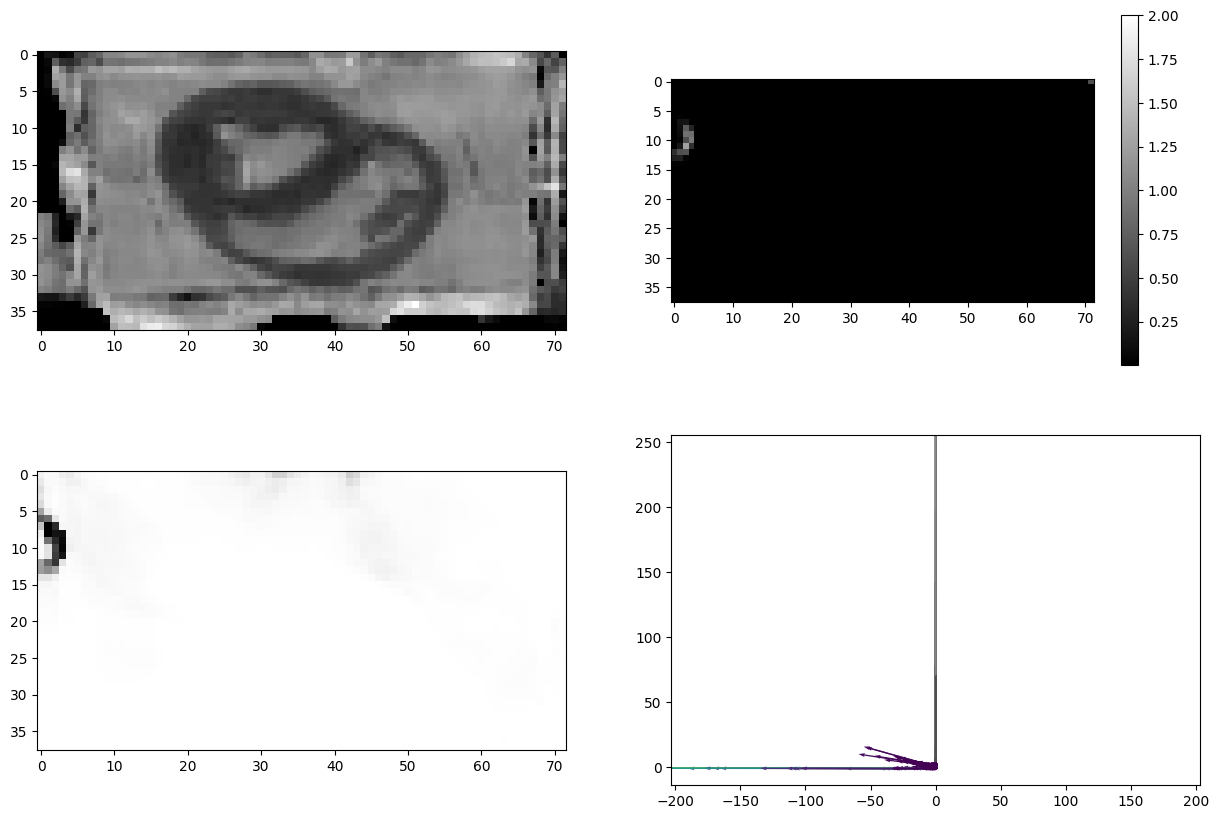

In [120]:
pred = ff_forwardpass_fiber(Xall, params_fiber)

dI = np.exp(pred[:,0])
df = np.exp(pred[:,1])
a = np.tanh(pred[:,2])
b = np.tanh(pred[:,3])


f1 = a*np.sqrt(1 - b**2 + 1e-6)
f2 = np.sqrt(1 - a**2 + 1e-6)*np.sqrt(1 - b**2 + 1e-6)
f3 = b

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(dI.reshape((Nx, Ny)), cmap='gray')

plt.subplot(2,2,2)
plt.imshow(df.reshape((Nx, Ny)), vmax = 2,cmap='gray')
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(f1.reshape((Nx, Ny)), cmap='gray')

# plt.subplot(2,2,4)
# plt.imshow(f2.reshape((Nx, Ny)), cmap='gray')

plt.subplot(2,2,4)
plt.pcolor(X,Y,dI.reshape((Nx, Ny)), cmap='gray') # mapa de difusión dI
plt.quiver(Xall[:,0], Xall[:,1], f1, f2, f3) # flechas con la dirección de cada fibra
plt.axis('equal')

(array([2.735e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

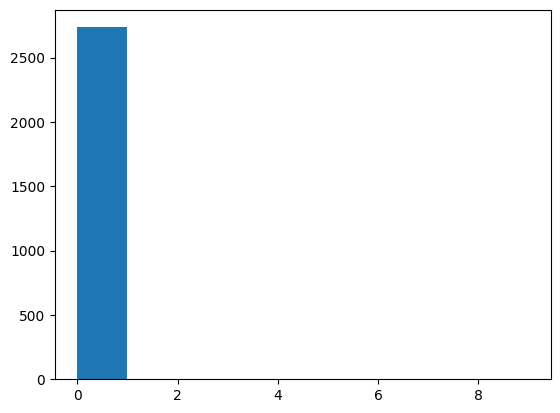

In [121]:
plt.hist(df, np.arange(0,10)) # Valores de df cercanos a 0, es decir de poca difusión

In [122]:
pred_I = vmap(ff_forwardpass, in_axes = (0, None))(input, params_probar) # error!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

pred_I = pred_I[...,0] + 1j*pred_I[...,1]

ui, vi, wi = dirs[selected_dirs].T # componentes de vectores de dirección de los gradientes de difusión.T
b_matrix = 1500*np.c_[ui**2, vi**2, wi**2, 2*ui*vi, 2*ui*wi, 2*vi*wi] # b vale 1500 y se construye la matriz b con él
b_inv = np.linalg.pinv(b_matrix) # pseudoinversa de b

print(pred_I.shape)

D_vec = vmap(lambda logM0, Is: b_inv @ (np.log(abs(Is)) - logM0), in_axes = (0, 0))(logM0, pred_I.T) # vector D

D_mat = vmap(lambda D: np.array([[D[0], D[3], D[4]],
                                 [D[3], D[1], D[5]],
                                 [D[4], D[5], D[2]]]))(D_vec) # matriz D a partir de los valores de D

n_eigvals, n_eigvecs = np.linalg.eigh(D_mat) # calculo de auto vectores y valores.


(12, 2736)


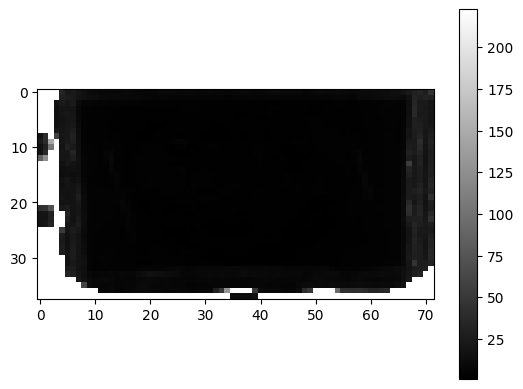

In [123]:
I_pred = log_forward_model(input_f[0], params_fiber) # resultado del modelo predictivo

plt.imshow(((I_pred - np.abs(pred_I[0]))**2).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()

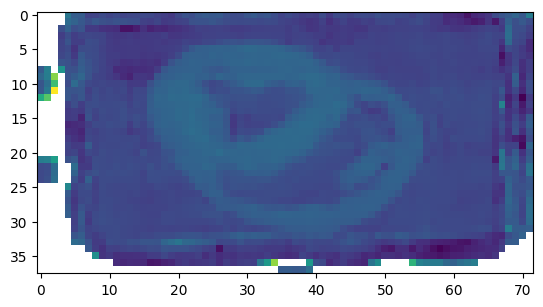

In [143]:
map = n_eigvals[:,0].reshape((Nx, Ny))
plt.imshow(map, cmap='gray') # valor propio más bajo de cada voxel, de poca difusión
# es decir, el voxel con menos difusión de todos

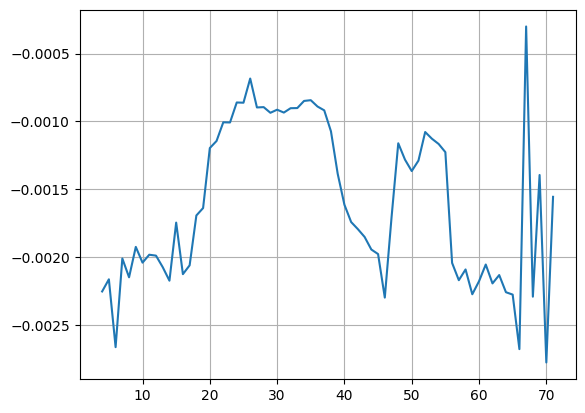

In [144]:
# generamos una máscara del miocardio, para ello vemos en qué intensidad de gris segmentar

# plt.figure(figsize=(10,10))

y_linea = 20

# for i in enumerate(selected_dirs):
#     # plt.subplot(3,3,i)
#     img = np.abs(image[:,:,24,4,i])
#     linea = img[y_linea, :]
#     plt.grid(True)
#     plt.plot(linea)
# plt.show()

linea = map[y_linea, :]
plt.grid(True)
plt.plot(linea)
plt.show()

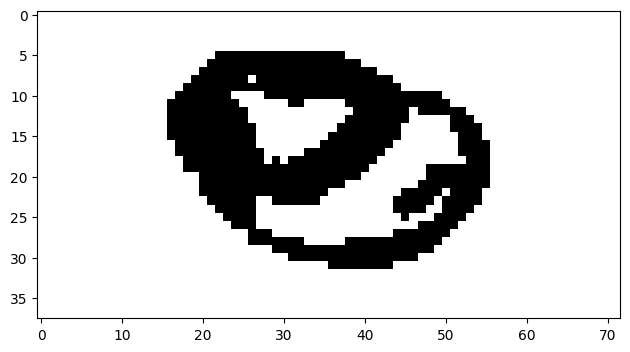

In [170]:
# del histograma anterior, parece ser que 0.08 quizá sea un buen punto donde umbralizar para dejar pasar solo el miocardio
# estas máscaras las usaremos más abajo, para segmentar el np.dot de las direcciones del modelo y las reales y ver qué tal dan

import jax.numpy as jnp

def umbralizacion(X, t):
    Y = jnp.zeros_like(X)
    mask = X < t
    Y = Y.at[mask].set(255)
    return Y

# mascaras = []
# for i, idx in enumerate(selected_dirs):
#     plt.subplot(4, 3, i + 1)
#     img = np.abs(np.array(image[:, :, 24, 4, idx]))
#     Y = umbralizacion(img, 0.06)
#     mascaras.append(Y)
#     plt.imshow(Y, cmap='gray')
# plt.tight_layout()
# plt.show()

import jax.numpy as jnp

Y = umbralizacion(map, -0.0015)
img_recortada = jnp.full_like(Y, 255)
img_recortada = img_recortada.at[2:32, 10:60].set(Y[2:32, 10:60])

plt.imshow(img_recortada, cmap='gray')
plt.tight_layout()
plt.show()



<ipython-input-125-874530969>:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(X,Y,n_eigvals[:,0].reshape((Nx,Ny)), cmap='gray')


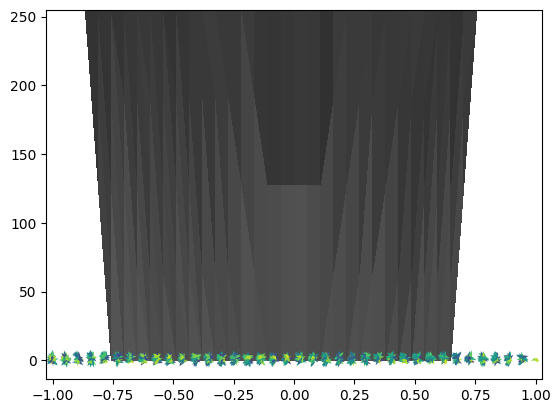

In [125]:
plt.pcolor(X,Y,n_eigvals[:,0].reshape((Nx,Ny)), cmap='gray')
plt.quiver(Xall[:,0], Xall[:,1], n_eigvecs[:,0,0], n_eigvecs[:,0,1], n_eigvecs[:,0,2]) # se dibujan las direcciones del valor propio más bajo en cada voxel
# eigvecs[:,0,0] es en x y así eigvecs[:,0,1] en y, Xall[:,0], Xall[:,1] son las coordenadas de cada voxel en 2D

In [126]:
ui, vi, wi = dirs[selected_dirs].T # componentes de vectores de dirección de los gradientes de difusión.T
b_matrix = 1500*np.c_[ui**2, vi**2, wi**2, 2*ui*vi, 2*ui*wi, 2*vi*wi] # b vale 1500 y se construye la matriz b con él
b_inv = np.linalg.pinv(b_matrix) # pseudoinversa de b

# original = image[:,:,22,0,0].copy()
# print(original.shape)
# print(logM0.shape)

input = []
for i,dir_idx in enumerate(selected_dirs): # son 12 puntos en selected_dirs
    input.append(slice[dir_idx])
input = np.array(input)

print(input.shape)
signal = input.reshape(12, -1)
print(signal.shape)

original = image.reshape(-1, len(selected_dirs))

D_vec = vmap(lambda logM0, Is: b_inv @ (np.log(abs(Is)) - logM0), in_axes = (0, 0))(logM0, signal.T) # vector D

D_mat = vmap(lambda D: np.array([[D[0], D[3], D[4]],
                                 [D[3], D[1], D[5]],
                                 [D[4], D[5], D[2]]]))(D_vec) # matriz D a partir de los valores de D

i_eigvals, i_eigvecs = np.linalg.eigh(D_mat) # calculo de auto vectores y valores.

(12, 38, 72)
(12, 2736)


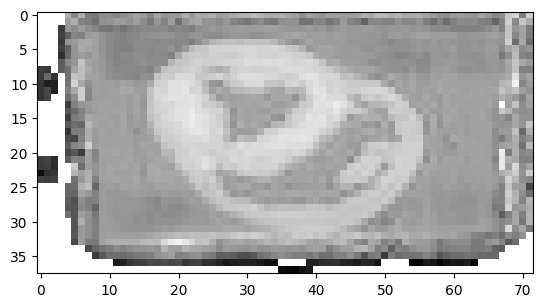

In [127]:
plt.imshow(i_eigvals[:,0].reshape((Nx, Ny)), cmap='gray') # valor propio más bajo de cada voxel, de poca difusión
# es decir, el voxel con menos difusión de todos

<ipython-input-132-3461993756>:1: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(X,Y,i_eigvals[:,0].reshape((Nx,Ny)), cmap='gray')


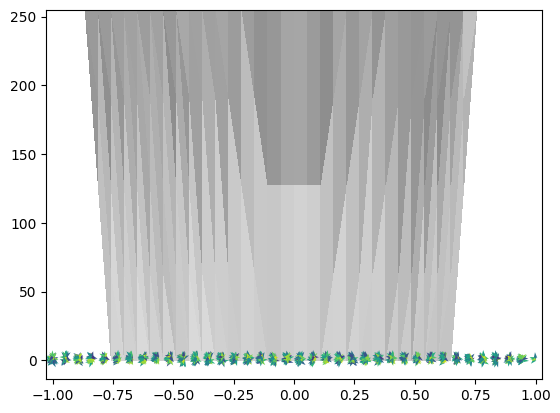

In [132]:
plt.pcolor(X,Y,i_eigvals[:,0].reshape((Nx,Ny)), cmap='gray')
plt.quiver(Xall[:,0], Xall[:,1], i_eigvecs[:,0,0], i_eigvecs[:,0,1], i_eigvecs[:,0,2]) # se dibujan las direcciones del valor propio más bajo en cada voxel
# eigvecs[:,0,0] es en x y así eigvecs[:,0,1] en y, Xall[:,0], Xall[:,1] son las coordenadas de cada voxel en 2D

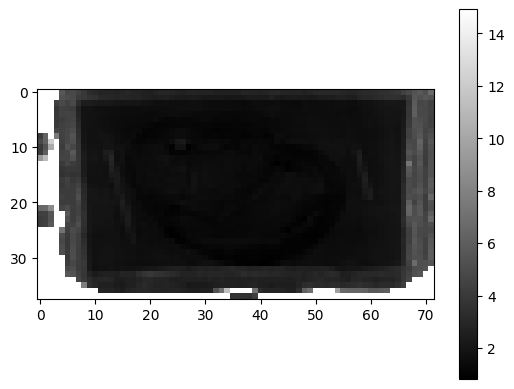

In [129]:
plt.imshow(((np.abs(I_pred) - np.abs(signal[0]))).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()

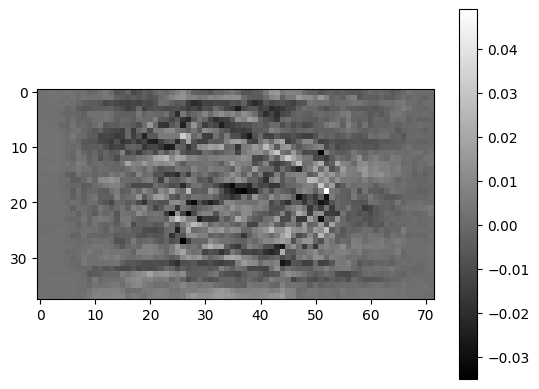

In [130]:
plt.imshow(((np.abs(pred_I[0]) - np.abs(signal[0]))).reshape((Nx, Ny)), cmap='gray') # (resultado - resultado de ff_forwardpass) ^ 2
plt.colorbar()

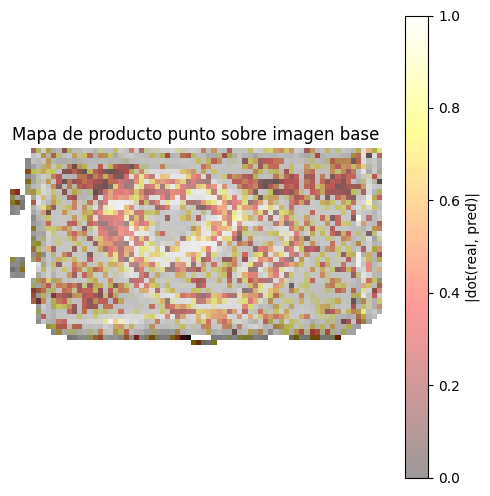

In [131]:
i_main_evecs = i_eigvecs[:, :, 1]
n_main_evecs = n_eigvecs[:, :, 1]

dot_prods = np.sum(i_main_evecs * n_main_evecs, axis=1)
dot_map = np.arccos(np.clip(np.abs(dot_prods), 0, 1))

# Si quieres verlo como imagen:
dot_map_img = dot_map.reshape((Nx, Ny))  # Ajusta al tamaño espacial original

plt.figure(figsize=(6,6))

# Imagen base en escala de grises (e.g. eigenval principal)
plt.imshow(i_eigvals[:,0].reshape((Nx, Ny)), cmap='gray')

# Mapa de producto punto encima, con transparencia
plt.imshow(dot_map_img, cmap='hot', vmin=0, vmax=1, alpha=0.4)  # alpha entre 0 y 1

plt.title('Mapa de producto punto sobre imagen base')
plt.colorbar(label='|dot(real, pred)|')
plt.axis('off')
plt.show()



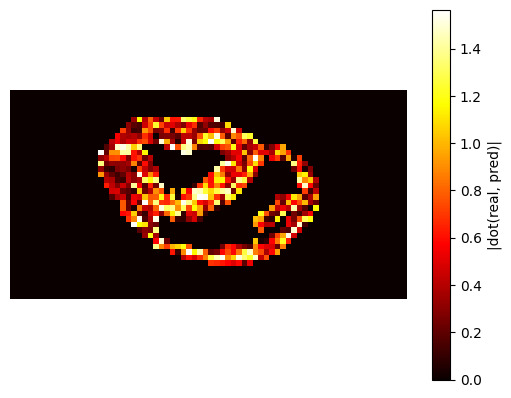

In [178]:
masked_img = dot_map_img * (img_recortada < 10)
plt.imshow(masked_img, cmap='hot')  # alpha entre 0 y 1

plt.colorbar(label='|dot(real, pred)|')
plt.axis('off')
plt.show()
